In [135]:
import datetime
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import warnings

from contextlib import contextmanager
from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

FEATS_EXCLUDED = ['first_active_month', 'target', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
                  'OOF_PRED', 'month_0']

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# rmse
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
    
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

# reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
    
# preprocessing train & test
def train_test(num_rows=None):

    # load csv
    train_df = pd.read_csv('train.csv', index_col=['card_id'], nrows=num_rows)
    test_df = pd.read_csv('test.csv', index_col=['card_id'], nrows=num_rows)

    print("Train samples: {}, test samples: {}".format(len(train_df), len(test_df)))

    # outlier
    train_df['outliers'] = 0
    train_df.loc[train_df['target'] < -30, 'outliers'] = 1

    # set target as nan
    test_df['target'] = np.nan

    # merge
    df = train_df.append(test_df)

    del train_df, test_df
    gc.collect()

    # to datetime
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])

    # datetime features
    df['quarter'] = df['first_active_month'].dt.quarter
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days

    df['days_feature1'] = df['elapsed_time'] * df['feature_1']
    df['days_feature2'] = df['elapsed_time'] * df['feature_2']
    df['days_feature3'] = df['elapsed_time'] * df['feature_3']

    df['days_feature1_ratio'] = df['feature_1'] / df['elapsed_time']
    df['days_feature2_ratio'] = df['feature_2'] / df['elapsed_time']
    df['days_feature3_ratio'] = df['feature_3'] / df['elapsed_time']

    # one hot encoding
    df, cols = one_hot_encoder(df, nan_as_category=False)

    for f in ['feature_1','feature_2','feature_3']:
        order_label = df.groupby([f])['outliers'].mean()
        df[f] = df[f].map(order_label)

    df['feature_sum'] = df['feature_1'] + df['feature_2'] + df['feature_3']
    df['feature_mean'] = df['feature_sum']/3
    df['feature_max'] = df[['feature_1', 'feature_2', 'feature_3']].max(axis=1)
    df['feature_min'] = df[['feature_1', 'feature_2', 'feature_3']].min(axis=1)
    df['feature_var'] = df[['feature_1', 'feature_2', 'feature_3']].std(axis=1)

    return df

# preprocessing historical transactions
def historical_transactions(num_rows=None):
    # load csv
    hist_df = pd.read_csv('historical_transactions.csv', nrows=num_rows)

    # fillna
    hist_df['category_2'].fillna(1.0,inplace=True)
    hist_df['category_3'].fillna('A',inplace=True)
    hist_df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    #hist_df['installments'].replace(-1, np.nan,inplace=True)
    #hist_df['installments'].replace(999, np.nan,inplace=True)

    # trim
    hist_df['purchase_amount'] = hist_df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    hist_df['authorized_flag'] = hist_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    hist_df['category_1'] = hist_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    hist_df['category_3'] = hist_df['category_3'].map({'A':0, 'B':1, 'C':2})

    # datetime features
    hist_df['purchase_date'] = pd.to_datetime(hist_df['purchase_date'])
    hist_df['month'] = hist_df['purchase_date'].dt.month
    hist_df['day'] = hist_df['purchase_date'].dt.day
    hist_df['hour'] = hist_df['purchase_date'].dt.hour
    hist_df['weekofyear'] = hist_df['purchase_date'].dt.weekofyear
    hist_df['weekday'] = hist_df['purchase_date'].dt.weekday
    hist_df['weekend'] = (hist_df['purchase_date'].dt.weekday >=5).astype(int)

    # additional features
    hist_df['price'] = hist_df['purchase_amount'] / hist_df['installments']

    #Christmas : December 25 2017
    hist_df['Christmas_Day_2017']=(pd.to_datetime('2017-12-25')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Mothers Day: May 14 2017
    hist_df['Mothers_Day_2017']=(pd.to_datetime('2017-06-04')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #fathers day: August 13 2017
    hist_df['fathers_day_2017']=(pd.to_datetime('2017-08-13')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Childrens day: October 12 2017
    hist_df['Children_day_2017']=(pd.to_datetime('2017-10-12')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Valentine's Day : 12th June, 2017
    hist_df['Valentine_Day_2017']=(pd.to_datetime('2017-06-12')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Black Friday : 24th November 2017
    hist_df['Black_Friday_2017']=(pd.to_datetime('2017-11-24') - hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    #2018
    #Mothers Day: May 13 2018
    hist_df['Mothers_Day_2018']=(pd.to_datetime('2018-05-13')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    hist_df['month_diff'] = ((datetime.datetime.today() - hist_df['purchase_date']).dt.days)//30
    hist_df['month_diff'] += hist_df['month_lag']

    # additional features
    hist_df['duration'] = hist_df['purchase_amount']*hist_df['month_diff']
    hist_df['amount_month_ratio'] = hist_df['purchase_amount']/hist_df['month_diff']

    # reduce memory usage
    hist_df = reduce_mem_usage(hist_df)

    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id']
    col_seas = ['month', 'hour', 'weekofyear', 'weekday', 'day']

    aggs = {}
    for col in col_unique:
        aggs[col] = ['nunique']

    for col in col_seas:
        aggs[col] = ['nunique', 'mean', 'min', 'max']

    aggs['purchase_amount'] = ['sum','max','min','mean','var','skew']
    aggs['installments'] = ['sum','max','mean','var','skew']
    aggs['purchase_date'] = ['max','min']
    aggs['month_lag'] = ['max','min','mean','var','skew']
    aggs['month_diff'] = ['max','min','mean','var','skew']
    aggs['authorized_flag'] = ['mean']
    aggs['weekend'] = ['mean'] # overwrite
    aggs['weekday'] = ['mean'] # overwrite
    aggs['day'] = ['nunique', 'mean', 'min'] # overwrite
    aggs['category_1'] = ['mean']
    aggs['category_2'] = ['mean']
    aggs['category_3'] = ['mean']
    aggs['card_id'] = ['size','count']
    aggs['price'] = ['sum','mean','max','min','var']
    aggs['Christmas_Day_2017'] = ['mean']
    aggs['Mothers_Day_2017'] = ['mean']
    aggs['fathers_day_2017'] = ['mean']
    aggs['Children_day_2017'] = ['mean']
    aggs['Valentine_Day_2017'] = ['mean']
    aggs['Black_Friday_2017'] = ['mean']
    aggs['Mothers_Day_2018'] = ['mean']
    aggs['duration']=['mean','min','max','var','skew']
    aggs['amount_month_ratio']=['mean','min','max','var','skew']

    for col in ['category_2','category_3']:
        hist_df[col+'_mean'] = hist_df.groupby([col])['purchase_amount'].transform('mean')
        hist_df[col+'_min'] = hist_df.groupby([col])['purchase_amount'].transform('min')
        hist_df[col+'_max'] = hist_df.groupby([col])['purchase_amount'].transform('max')
        hist_df[col+'_sum'] = hist_df.groupby([col])['purchase_amount'].transform('sum')
        aggs[col+'_mean'] = ['mean']

    hist_df = hist_df.reset_index().groupby('card_id').agg(aggs)

    # change column name
    hist_df.columns = pd.Index([e[0] + "_" + e[1] for e in hist_df.columns.tolist()])
    hist_df.columns = ['hist_'+ c for c in hist_df.columns]

    hist_df['hist_purchase_date_diff'] = (hist_df['hist_purchase_date_max']-hist_df['hist_purchase_date_min']).dt.days
    hist_df['hist_purchase_date_average'] = hist_df['hist_purchase_date_diff']/hist_df['hist_card_id_size']
    hist_df['hist_purchase_date_uptonow'] = (datetime.datetime.today()-hist_df['hist_purchase_date_max']).dt.days
    hist_df['hist_purchase_date_uptomin'] = (datetime.datetime.today()-hist_df['hist_purchase_date_min']).dt.days

    # reduce memory usage
    hist_df = reduce_mem_usage(hist_df)

    return hist_df
    
# preprocessing new_merchant_transactions
def new_merchant_transactions(num_rows=None):
    # load csv
    new_merchant_df = pd.read_csv('new_merchant_transactions.csv', nrows=num_rows)

    # fillna
    new_merchant_df['category_2'].fillna(1.0,inplace=True)
    new_merchant_df['category_3'].fillna('A',inplace=True)
    new_merchant_df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    new_merchant_df['installments'].replace(-1, np.nan,inplace=True)
    new_merchant_df['installments'].replace(999, np.nan,inplace=True)

    # trim
    new_merchant_df['purchase_amount'] = new_merchant_df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    new_merchant_df['authorized_flag'] = new_merchant_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    new_merchant_df['category_1'] = new_merchant_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    new_merchant_df['category_3'] = new_merchant_df['category_3'].map({'A':0, 'B':1, 'C':2}).astype(int)

    # datetime features
    new_merchant_df['purchase_date'] = pd.to_datetime(new_merchant_df['purchase_date'])
    new_merchant_df['month'] = new_merchant_df['purchase_date'].dt.month
    new_merchant_df['day'] = new_merchant_df['purchase_date'].dt.day
    new_merchant_df['hour'] = new_merchant_df['purchase_date'].dt.hour
    new_merchant_df['weekofyear'] = new_merchant_df['purchase_date'].dt.weekofyear
    new_merchant_df['weekday'] = new_merchant_df['purchase_date'].dt.weekday
    new_merchant_df['weekend'] = (new_merchant_df['purchase_date'].dt.weekday >=5).astype(int)

    # additional features
    new_merchant_df['price'] = new_merchant_df['purchase_amount'] / new_merchant_df['installments']

    #Christmas : December 25 2017
    new_merchant_df['Christmas_Day_2017']=(pd.to_datetime('2017-12-25')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Childrens day: October 12 2017
    new_merchant_df['Children_day_2017']=(pd.to_datetime('2017-10-12')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Black Friday : 24th November 2017
    new_merchant_df['Black_Friday_2017']=(pd.to_datetime('2017-11-24') - new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    #Mothers Day: May 13 2018
    new_merchant_df['Mothers_Day_2018']=(pd.to_datetime('2018-05-13')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    new_merchant_df['month_diff'] = ((datetime.datetime.today() - new_merchant_df['purchase_date']).dt.days)//30
    new_merchant_df['month_diff'] += new_merchant_df['month_lag']

    # additional features
    new_merchant_df['duration'] = new_merchant_df['purchase_amount']*new_merchant_df['month_diff']
    new_merchant_df['amount_month_ratio'] = new_merchant_df['purchase_amount']/new_merchant_df['month_diff']

    # reduce memory usage
    new_merchant_df = reduce_mem_usage(new_merchant_df)

    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id']
    col_seas = ['month', 'hour', 'weekofyear', 'weekday', 'day']

    aggs = {}
    for col in col_unique:
        aggs[col] = ['nunique']

    for col in col_seas:
        aggs[col] = ['nunique', 'mean', 'min', 'max']

    aggs['purchase_amount'] = ['sum','max','min','mean','var','skew']
    aggs['installments'] = ['sum','max','mean','var','skew']
    aggs['purchase_date'] = ['max','min']
    aggs['month_lag'] = ['max','min','mean','var','skew']
    aggs['month_diff'] = ['mean','var','skew']
    aggs['weekend'] = ['mean']
    aggs['month'] = ['mean', 'min', 'max']
    aggs['weekday'] = ['mean', 'min', 'max']
    aggs['category_1'] = ['mean']
    aggs['category_2'] = ['mean']
    aggs['category_3'] = ['mean']
    aggs['card_id'] = ['size','count']
    aggs['price'] = ['mean','max','min','var']
    aggs['Christmas_Day_2017'] = ['mean']
    aggs['Children_day_2017'] = ['mean']
    aggs['Black_Friday_2017'] = ['mean']
    aggs['Mothers_Day_2018'] = ['mean']
    aggs['duration']=['mean','min','max','var','skew']
    aggs['amount_month_ratio']=['mean','min','max','var','skew']

    for col in ['category_2','category_3']:
        new_merchant_df[col+'_mean'] = new_merchant_df.groupby([col])['purchase_amount'].transform('mean')
        new_merchant_df[col+'_min'] = new_merchant_df.groupby([col])['purchase_amount'].transform('min')
        new_merchant_df[col+'_max'] = new_merchant_df.groupby([col])['purchase_amount'].transform('max')
        new_merchant_df[col+'_sum'] = new_merchant_df.groupby([col])['purchase_amount'].transform('sum')
        aggs[col+'_mean'] = ['mean']

    new_merchant_df = new_merchant_df.reset_index().groupby('card_id').agg(aggs)

    # change column name
    new_merchant_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_merchant_df.columns.tolist()])
    new_merchant_df.columns = ['new_'+ c for c in new_merchant_df.columns]

    new_merchant_df['new_purchase_date_diff'] = (new_merchant_df['new_purchase_date_max']-new_merchant_df['new_purchase_date_min']).dt.days
    new_merchant_df['new_purchase_date_average'] = new_merchant_df['new_purchase_date_diff']/new_merchant_df['new_card_id_size']
    new_merchant_df['new_purchase_date_uptonow'] = (datetime.datetime.today()-new_merchant_df['new_purchase_date_max']).dt.days
    new_merchant_df['new_purchase_date_uptomin'] = (datetime.datetime.today()-new_merchant_df['new_purchase_date_min']).dt.days

    # reduce memory usage
    new_merchant_df = reduce_mem_usage(new_merchant_df)

    return new_merchant_df

# additional features
def additional_features(df):
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_last_buy'] = (df['new_purchase_date_max'] - df['first_active_month']).dt.days

    date_features=['hist_purchase_date_max','hist_purchase_date_min',
                   'new_purchase_date_max', 'new_purchase_date_min']

    for f in date_features:
        df[f] = df[f].astype(np.int64) * 1e-9

    df['card_id_total'] = df['new_card_id_size']+df['hist_card_id_size']
    df['card_id_cnt_total'] = df['new_card_id_count']+df['hist_card_id_count']
    df['card_id_cnt_ratio'] = df['new_card_id_count']/df['hist_card_id_count']
    df['purchase_amount_total'] = df['new_purchase_amount_sum']+df['hist_purchase_amount_sum']
    df['purchase_amount_mean'] = df['new_purchase_amount_mean']+df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_purchase_amount_max']+df['hist_purchase_amount_max']
    df['purchase_amount_min'] = df['new_purchase_amount_min']+df['hist_purchase_amount_min']
    df['purchase_amount_ratio'] = df['new_purchase_amount_sum']/df['hist_purchase_amount_sum']
    df['month_diff_mean'] = df['new_month_diff_mean']+df['hist_month_diff_mean']
    df['month_diff_ratio'] = df['new_month_diff_mean']/df['hist_month_diff_mean']
    df['month_lag_mean'] = df['new_month_lag_mean']+df['hist_month_lag_mean']
    df['month_lag_max'] = df['new_month_lag_max']+df['hist_month_lag_max']
    df['month_lag_min'] = df['new_month_lag_min']+df['hist_month_lag_min']
    df['category_1_mean'] = df['new_category_1_mean']+df['hist_category_1_mean']
    df['installments_total'] = df['new_installments_sum']+df['hist_installments_sum']
    df['installments_mean'] = df['new_installments_mean']+df['hist_installments_mean']
    df['installments_max'] = df['new_installments_max']+df['hist_installments_max']
    df['installments_ratio'] = df['new_installments_sum']/df['hist_installments_sum']
    df['price_total'] = df['purchase_amount_total'] / df['installments_total']
    df['price_mean'] = df['purchase_amount_mean'] / df['installments_mean']
    df['price_max'] = df['purchase_amount_max'] / df['installments_max']
    df['duration_mean'] = df['new_duration_mean']+df['hist_duration_mean']
    df['duration_min'] = df['new_duration_min']+df['hist_duration_min']
    df['duration_max'] = df['new_duration_max']+df['hist_duration_max']
    df['amount_month_ratio_mean']=df['new_amount_month_ratio_mean']+df['hist_amount_month_ratio_mean']
    df['amount_month_ratio_min']=df['new_amount_month_ratio_min']+df['hist_amount_month_ratio_min']
    df['amount_month_ratio_max']=df['new_amount_month_ratio_max']+df['hist_amount_month_ratio_max']
    df['new_CLV'] = df['new_card_id_count'] * df['new_purchase_amount_sum'] / df['new_month_diff_mean']
    df['hist_CLV'] = df['hist_card_id_count'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
    df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']

    return df


In [136]:
def main(debug=False):
    num_rows = 10000 if debug else None
    with timer("train & test"):
        df = train_test(num_rows)
    with timer("historical transactions"):
        df = pd.merge(df, historical_transactions(num_rows), on='card_id', how='outer')
    with timer("new merchants"):
        df = pd.merge(df, new_merchant_transactions(num_rows), on='card_id', how='outer')
    with timer("additional features"):
        df = additional_features(df)
    with timer("split train & test"):
        train_df = df[df['target'].notnull()]
        test_df = df[df['target'].isnull()]
    return df

In [167]:
df = main(debug=100)

Train samples: 10000, test samples: 10000
train & test - done in 0s
Memory usage after optimization is: 0.62 MB
Decreased by 73.8%
Memory usage after optimization is: 0.01 MB
Decreased by 59.5%
historical transactions - done in 0s
Memory usage after optimization is: 0.60 MB
Decreased by 71.9%
Memory usage after optimization is: 0.12 MB
Decreased by 57.6%
new merchants - done in 1s
additional features - done in 0s
split train & test - done in 0s


In [168]:
df.reset_index(inplace=True)

In [120]:
df.head()

,card_id,feature_1,feature_2,feature_3,first_active_month,outliers,target,quarter,elapsed_time,days_feature1,...,price_max,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio
0,C_ID_92a2005557,0.012225,0.007989,0.010612,2017-06-01,0.0,-0.820283,2.0,635.0,3175.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C_ID_3d0044924f,0.008172,0.010775,0.008784,2017-01-01,0.0,0.392913,1.0,786.0,3144.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C_ID_d639edf6cd,0.010589,0.007989,0.008784,2016-08-01,0.0,0.688056,3.0,939.0,1878.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C_ID_186d6a6901,0.008172,0.011152,0.008784,2017-09-01,0.0,0.142495,3.0,543.0,2172.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C_ID_cdbd2c0db2,0.001592,0.011152,0.008784,2017-11-01,0.0,-0.159749,4.0,482.0,482.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
#df.to_csv('df_2.csv',index = False)
df=pd.read_csv('df_2.csv')

In [184]:
df_combine = pd.read_csv('df_combine2.csv')
df=df.merge(df_combine,on='card_id',how='left')

In [185]:
df_new=df.drop(columns= ['first_active_month', 
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
                  'quarter'])
df_new.replace([np.inf, -np.inf], np.nan,inplace=True)

In [186]:
len(df_new)

325540

In [172]:
pd.isnull(df).sum().sort_values(ascending=False).head(30)/len(df)

month_diff_mean            1.000000
month_lag_mean             1.000000
price_total                1.000000
installments_ratio         1.000000
installments_max           1.000000
installments_mean          1.000000
installments_total         1.000000
category_1_mean            1.000000
month_lag_min              1.000000
month_lag_max              1.000000
month_diff_ratio           1.000000
duration_mean              1.000000
purchase_amount_ratio      1.000000
purchase_amount_min        1.000000
purchase_amount_max        1.000000
purchase_amount_mean       1.000000
purchase_amount_total      1.000000
card_id_cnt_ratio          1.000000
card_id_cnt_total          1.000000
card_id_total              1.000000
price_max                  1.000000
price_mean                 1.000000
duration_min               1.000000
CLV_ratio                  1.000000
amount_month_ratio_mean    1.000000
amount_month_ratio_min     1.000000
amount_month_ratio_max     1.000000
duration_max               1

In [193]:
sample=df_new#.sample(frac = 0.2)
train = sample[sample['target'].notnull()]
test = sample[sample['target'].isnull()]

In [194]:
y = train['target']
X = train.drop(columns=['target','card_id'])
#X_new = X.fillna(0)

X_test = test.drop(columns = ['target','card_id','outliers'])
#X_test = X_test.fillna(0)

In [195]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.0, random_state = 42)

In [196]:
X_test_columns=X_test.columns
len(X_test_columns)

207

In [197]:
n_fold = 5
param = {'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.005,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 70,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**n_fold),
                'bagging_seed':int(2**n_fold),
                'drop_seed':int(2**n_fold)}
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=4590)
oof = np.zeros(len(X_train))
predictions1 = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train,X_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(X_train.iloc[trn_idx][X_test_columns], label=y_train.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(X_train.iloc[val_idx][X_test_columns], label=y_train.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(X_train.iloc[val_idx][X_test_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_test_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions1 += clf.predict(X_test[X_test_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, y_train))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.72194	valid_1's rmse: 3.74346
[200]	training's rmse: 3.65036	valid_1's rmse: 3.69399
[300]	training's rmse: 3.60314	valid_1's rmse: 3.66925
[400]	training's rmse: 3.56748	valid_1's rmse: 3.65525
[500]	training's rmse: 3.53827	valid_1's rmse: 3.64674
[600]	training's rmse: 3.51537	valid_1's rmse: 3.64061
[700]	training's rmse: 3.49607	valid_1's rmse: 3.63685
[800]	training's rmse: 3.4797	valid_1's rmse: 3.63449
[900]	training's rmse: 3.46588	valid_1's rmse: 3.63305
[1000]	training's rmse: 3.45332	valid_1's rmse: 3.63149
[1100]	training's rmse: 3.44177	valid_1's rmse: 3.6304
[1200]	training's rmse: 3.43031	valid_1's rmse: 3.62979
[1300]	training's rmse: 3.4198	valid_1's rmse: 3.62915
[1400]	training's rmse: 3.40956	valid_1's rmse: 3.62841
[1500]	training's rmse: 3.39906	valid_1's rmse: 3.62795
[1600]	training's rmse: 3.38914	valid_1's rmse: 3.62777
[1700]	training's rmse: 3.37913	valid_1's rmse

3.6494340561776

In [182]:
print(np.sqrt(mean_squared_error(y_val, predictions1)))

2.989811101573272


In [165]:
import warnings
warnings.filterwarnings('ignore') 

In [203]:
n_fold = 5
param = {'task': 'train',
                'boosting': 'dart',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**n_fold),
                'bagging_seed':int(2**n_fold),
                'drop_seed':int(2**n_fold)}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train,X_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(X_train.iloc[trn_idx][X_test_columns], label=y_train.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(X_train.iloc[val_idx][X_test_columns], label=y_train.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(X_train.iloc[val_idx][X_test_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_test_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test[X_test_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, y_train))

fold 0
[100]	training's rmse: 3.7478	valid_1's rmse: 3.76453
[200]	training's rmse: 3.71937	valid_1's rmse: 3.74282
[300]	training's rmse: 3.6758	valid_1's rmse: 3.7118
[400]	training's rmse: 3.64671	valid_1's rmse: 3.69452
[500]	training's rmse: 3.62924	valid_1's rmse: 3.68535
[600]	training's rmse: 3.60026	valid_1's rmse: 3.67156
[700]	training's rmse: 3.58575	valid_1's rmse: 3.66723
[800]	training's rmse: 3.56729	valid_1's rmse: 3.66157
[900]	training's rmse: 3.54532	valid_1's rmse: 3.65371
[1000]	training's rmse: 3.52143	valid_1's rmse: 3.6473
[1100]	training's rmse: 3.5067	valid_1's rmse: 3.64488
[1200]	training's rmse: 3.48599	valid_1's rmse: 3.64136
[1300]	training's rmse: 3.47107	valid_1's rmse: 3.63948
[1400]	training's rmse: 3.46206	valid_1's rmse: 3.63897
[1500]	training's rmse: 3.44725	valid_1's rmse: 3.63725
[1600]	training's rmse: 3.43885	valid_1's rmse: 3.63711
[1700]	training's rmse: 3.4307	valid_1's rmse: 3.63653
[1800]	training's rmse: 3.4216	valid_1's rmse: 3.63647
[

[4900]	training's rmse: 3.13912	valid_1's rmse: 3.66166
[5000]	training's rmse: 3.13418	valid_1's rmse: 3.66178
[5100]	training's rmse: 3.12787	valid_1's rmse: 3.66201
[5200]	training's rmse: 3.12156	valid_1's rmse: 3.66209
[5300]	training's rmse: 3.11438	valid_1's rmse: 3.66253
[5400]	training's rmse: 3.10806	valid_1's rmse: 3.66286
[5500]	training's rmse: 3.10146	valid_1's rmse: 3.66297
[5600]	training's rmse: 3.09392	valid_1's rmse: 3.66276
[5700]	training's rmse: 3.08767	valid_1's rmse: 3.66301
[5800]	training's rmse: 3.08049	valid_1's rmse: 3.66333
[5900]	training's rmse: 3.07287	valid_1's rmse: 3.66364
[6000]	training's rmse: 3.06585	valid_1's rmse: 3.66369
[6100]	training's rmse: 3.0601	valid_1's rmse: 3.66411
[6200]	training's rmse: 3.05521	valid_1's rmse: 3.66435
[6300]	training's rmse: 3.05086	valid_1's rmse: 3.66467
[6400]	training's rmse: 3.04258	valid_1's rmse: 3.66491
[6500]	training's rmse: 3.03584	valid_1's rmse: 3.66516
[6600]	training's rmse: 3.03059	valid_1's rmse: 3

[9600]	training's rmse: 2.89208	valid_1's rmse: 3.64885
[9700]	training's rmse: 2.88669	valid_1's rmse: 3.64907
[9800]	training's rmse: 2.88286	valid_1's rmse: 3.64924
[9900]	training's rmse: 2.87678	valid_1's rmse: 3.64969
[10000]	training's rmse: 2.87251	valid_1's rmse: 3.64992
fold 3
[100]	training's rmse: 3.74558	valid_1's rmse: 3.76865
[200]	training's rmse: 3.71662	valid_1's rmse: 3.74783
[300]	training's rmse: 3.671	valid_1's rmse: 3.718
[400]	training's rmse: 3.64124	valid_1's rmse: 3.70248
[500]	training's rmse: 3.62332	valid_1's rmse: 3.69445
[600]	training's rmse: 3.59326	valid_1's rmse: 3.68265
[700]	training's rmse: 3.57841	valid_1's rmse: 3.67776
[800]	training's rmse: 3.55975	valid_1's rmse: 3.67252
[900]	training's rmse: 3.53647	valid_1's rmse: 3.66713
[1000]	training's rmse: 3.51242	valid_1's rmse: 3.66114
[1100]	training's rmse: 3.49797	valid_1's rmse: 3.65918
[1200]	training's rmse: 3.47718	valid_1's rmse: 3.65601
[1300]	training's rmse: 3.46216	valid_1's rmse: 3.654

[4400]	training's rmse: 3.16046	valid_1's rmse: 3.67693
[4500]	training's rmse: 3.15274	valid_1's rmse: 3.67725
[4600]	training's rmse: 3.14698	valid_1's rmse: 3.67741
[4700]	training's rmse: 3.13833	valid_1's rmse: 3.67749
[4800]	training's rmse: 3.1313	valid_1's rmse: 3.67746
[4900]	training's rmse: 3.12244	valid_1's rmse: 3.67777
[5000]	training's rmse: 3.11704	valid_1's rmse: 3.67784
[5100]	training's rmse: 3.11139	valid_1's rmse: 3.67797
[5200]	training's rmse: 3.10493	valid_1's rmse: 3.6785
[5300]	training's rmse: 3.09773	valid_1's rmse: 3.67849
[5400]	training's rmse: 3.09094	valid_1's rmse: 3.67871
[5500]	training's rmse: 3.08343	valid_1's rmse: 3.67873
[5600]	training's rmse: 3.07592	valid_1's rmse: 3.67884
[5700]	training's rmse: 3.07104	valid_1's rmse: 3.67877
[5800]	training's rmse: 3.06391	valid_1's rmse: 3.67898
[5900]	training's rmse: 3.05647	valid_1's rmse: 3.67902
[6000]	training's rmse: 3.04952	valid_1's rmse: 3.67884
[6100]	training's rmse: 3.04306	valid_1's rmse: 3.

3.6605271608301693

In [208]:
print(np.sqrt(mean_squared_error(predictions, predictions1)))

0.3250679986052632


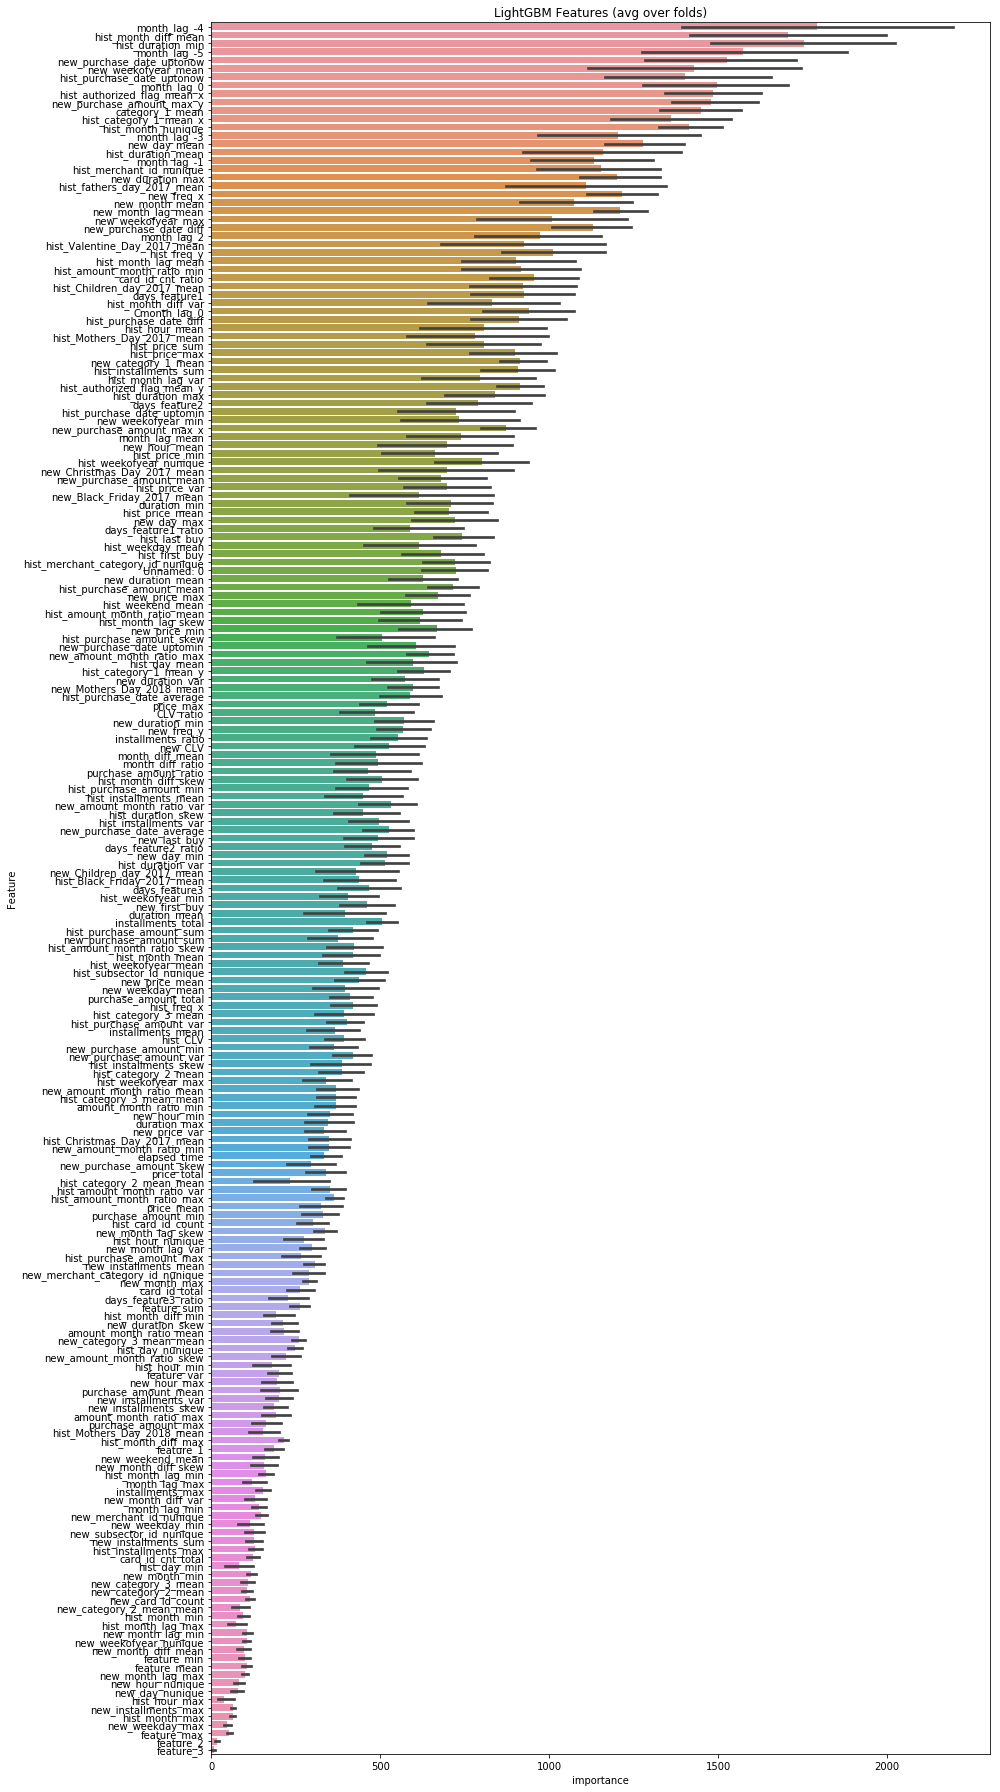

In [199]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

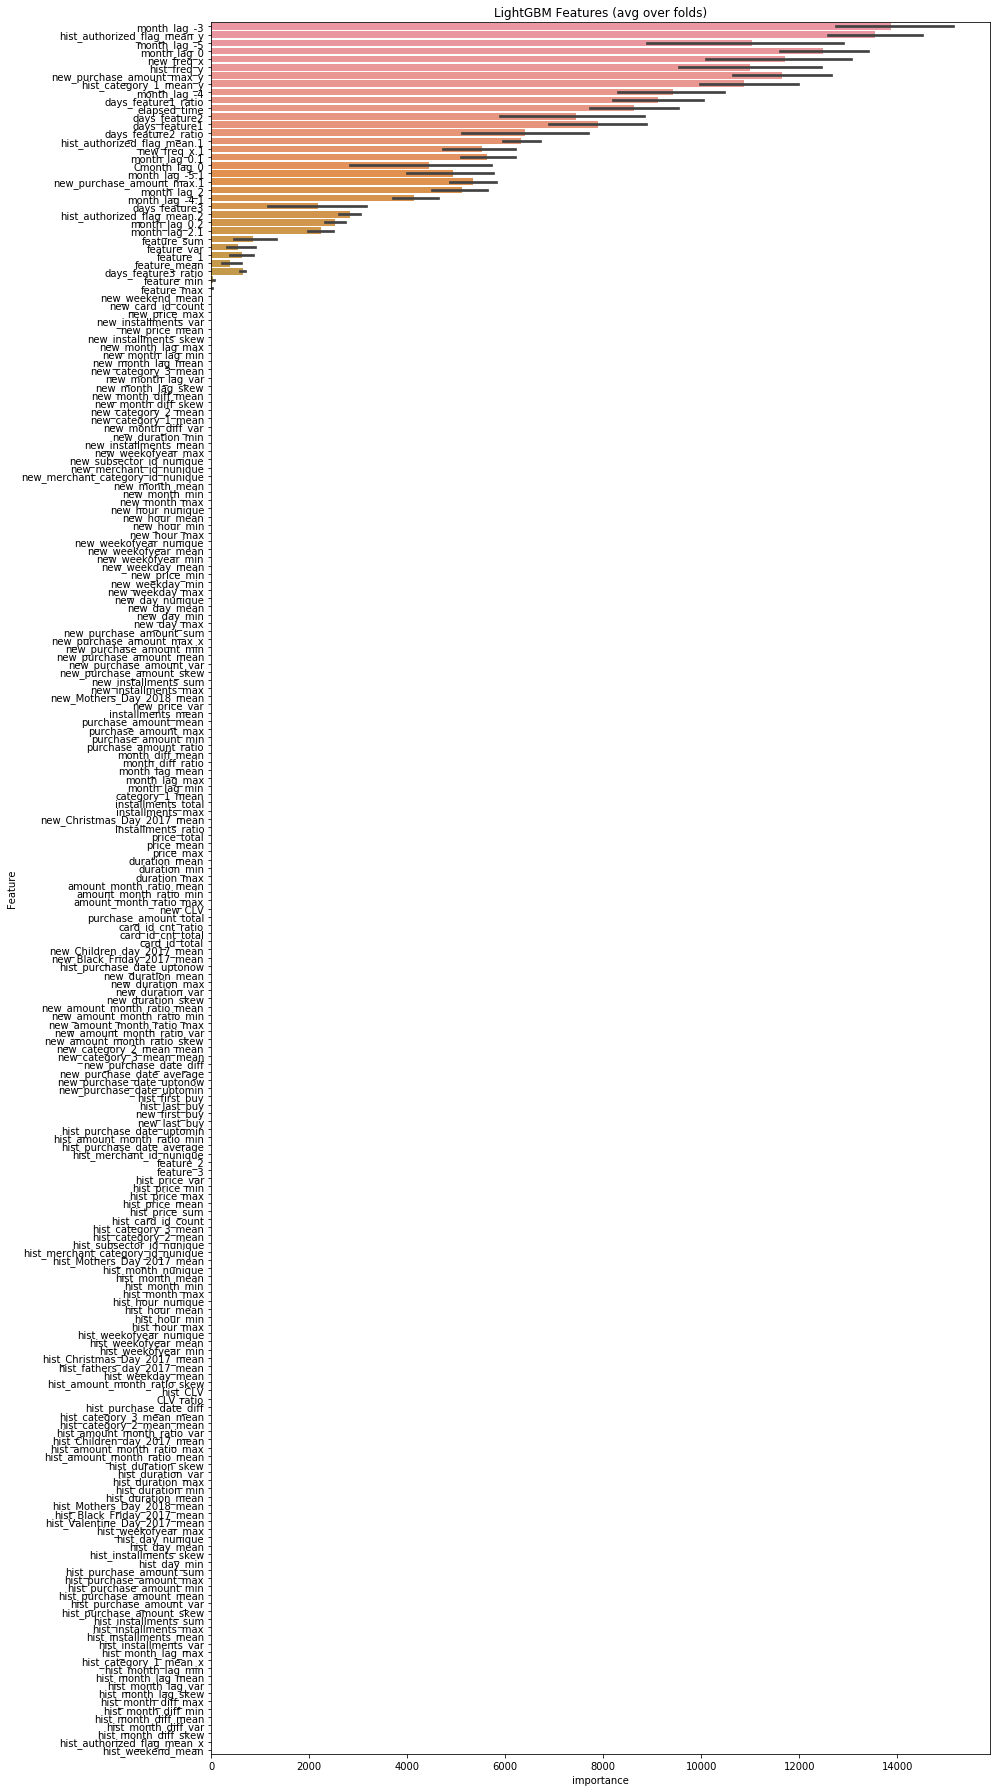

In [99]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [206]:
sub = pd.DataFrame(np.stack([test['card_id'],(predictions1+predictions)/2.0], axis=1), columns=['card_id','target'])
sub.to_csv('submission.csv',index=False)

In [207]:
sub.head()

,card_id,target
0,C_ID_0ab67a22ab,-3.38511
1,C_ID_130fd0cbdd,-0.232291
2,C_ID_b709037bc5,-0.954772
3,C_ID_d27d835a9f,-0.12713
4,C_ID_2b5e3df5c2,-1.56092
